In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Install Packages

In [14]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 686kB 28.6MB/s 


In [15]:
!pip install focal-loss

#LSTM Model


In [16]:
import numpy as np
import tensorflow as tf 
from tensorflow.keras.preprocessing import sequence
import os
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, MaxPool2D, Activation, LSTM
from tensorflow.keras.models import Model, load_model, Sequential
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint
import PIL
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
import tempfile
import matplotlib as mpl
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from focal_loss import BinaryFocalLoss

In [ ]:
select_model = Sequential(name='select_model')
select_model.add(LSTM(units=256, input_shape=(5000,1024), return_sequences=True))
select_model.add(LSTM(units=32,return_sequences=True))
select_model.add(Dense(1,activation='sigmoid'))
select_model.summary()

Model: "select_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5000, 256)         1311744   
_________________________________________________________________
lstm_1 (LSTM)                (None, 5000, 32)          36992     
_________________________________________________________________
dense (Dense)                (None, 5000, 1)           33        
Total params: 1,348,769
Trainable params: 1,348,769
Non-trainable params: 0
_________________________________________________________________


In [ ]:
select_model.save('my_model.h5')

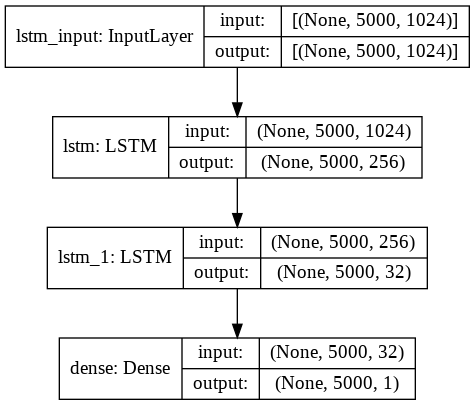

In [ ]:
tf.keras.utils.plot_model(select_model, to_file='model.png', show_shapes=True, show_layer_names=True)

##Training

###Training Dataset

In [ ]:
import h5py
import numpy as np
import os
import tensorflow as tf
import pandas as pd

def load_data_from_h5py(data_path):
  x_path = os.path.join(data_path, 'trainingdata_x_features.hdf5')
  y_path = os.path.join(data_path, 'trainingdata_y_indexs.hdf5')
  f1 = h5py.File(x_path,'r')
  x = np.array(f1["x"][:])
  f2 = h5py.File(y_path,'r')
  y = np.array(f2["y"][:])
  x = tf.convert_to_tensor(x, dtype=tf.float32)
  y = tf.convert_to_tensor(y, dtype=tf.float32)
  return x,y

In [ ]:
data_path = '/content/drive/MyDrive/MasterThesisProject/04_Models/LSTM-based_Temporal_Model/Training_Dataset/39_movie_feature_training_dataset'
x, y = load_data_from_h5py(data_path)
print(x.shape)
print(y.shape)

(39, 5000, 1024)
(39, 5000)


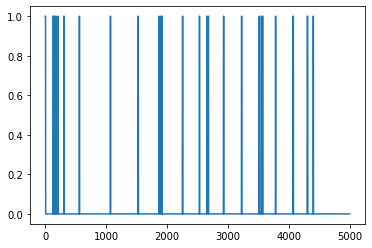

In [ ]:
y_arr = np.array(y)
plt.plot(y_arr[0])

In [ ]:
y_new = np.zeros((39,5000,1))

In [ ]:
y_new.shape

(39, 5000, 1)

In [ ]:
for i in range(y_new.shape[0]):
  for j in range(y_new.shape[1]):
    y_new[i,j,0] = y_arr[i,j]

In [ ]:
y_new[0,:,0]

array([1., 1., 1., ..., 0., 0., 0.])

In [ ]:
plt.plot(y_new[0,:,:])

In [ ]:
y_train = y_new

###Class Weights

In [ ]:
#Class imbalance methods
#Focal Loss Function for binary cross entry
#Cost Sensitive for different class weights
def binary_focal_loss(gamma=2.0, alpha=0.25):
    """
    Binary form of focal loss.
    focal_loss(p_t) = -alpha_t * (1 - p_t)**gamma * log(p_t)
        where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    alpha = tf.convert_to_tensor(alpha, dtype=tf.float32)
    gamma = tf.convert_to_tensor(gamma, dtype=tf.float32)

    def binary_focal_loss_fixed(y_true, y_pred):
        """
        y_true shape need be (None,1)
        y_pred need be compute after sigmoid
        """
        y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
        alpha_t = y_true*alpha + (K.ones_like(y_true)-y_true)*(1-alpha)
    
        p_t = y_true*y_pred + (K.ones_like(y_true)-y_true)*(K.ones_like(y_true)-y_pred) + K.epsilon()
        focal_loss = - alpha_t * K.pow((K.ones_like(y_true)-p_t),gamma) * K.log(p_t)
        return K.mean(focal_loss)
    return binary_focal_loss_fixed

In [ ]:
#Load metadata
#raw_df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/MT/Dataset/training/output_model/78_movie_dataset/78_movie_meta.csv')
#Look at the dataset imbalance
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))
neg = 4800
pos = 200
total = 5000
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

class_weights = {0.0:0.52,1.0:12.50}
class_weights


###Compile

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
select_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss=BinaryFocalLoss(gamma=2.0,pos_weight=12.50),
              metrics=METRICS)

### Training Details

In [ ]:
# Train the LSTM on the training data
result = select_model.fit(x, y_train, batch_size=8, epochs=200, verbose=1)

Epoch 1/200
5/5 [==============================] - 6s 473ms/step - loss: 0.4299 - tp: 9919.5000 - fp: 77802.3333 - tn: 39283.5000 - fn: 4661.3333 - accuracy: 0.4420 - precision: 0.1154 - recall: 0.5946 - auc: 0.5173
Epoch 2/200
5/5 [==============================] - 2s 478ms/step - loss: 0.3898 - tp: 13622.6667 - fp: 97143.0000 - tn: 19987.5000 - fn: 913.5000 - accuracy: 0.2454 - precision: 0.1220 - recall: 0.9521 - auc: 0.5579
Epoch 3/200
5/5 [==============================] - 2s 476ms/step - loss: 0.3827 - tp: 10980.8333 - fp: 76154.1667 - tn: 40975.6667 - fn: 3556.0000 - accuracy: 0.4076 - precision: 0.1247 - recall: 0.7392 - auc: 0.5510
Epoch 4/200
5/5 [==============================] - 2s 474ms/step - loss: 0.3752 - tp: 14266.0000 - fp: 101195.6667 - tn: 15945.8333 - fn: 259.1667 - accuracy: 0.2297 - precision: 0.1224 - recall: 0.9790 - auc: 0.5810
Epoch 5/200
5/5 [==============================] - 2s 475ms/step - loss: 0.3743 - tp: 14254.1667 - fp: 102955.8333 - tn: 14371.0000 - 

In [ ]:
select_model.save('/content/drive/MyDrive/MasterThesisProject/Models/LSTM-based_Temporal_Model/Model_Weight')

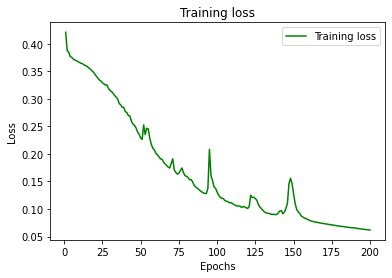

In [ ]:
loss = result.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

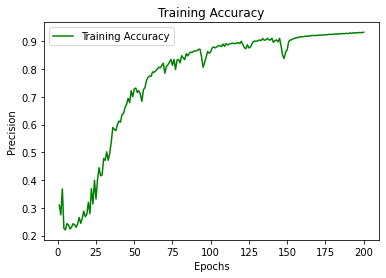

In [ ]:
acc = result.history['accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'g', label='Training Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training Accuracy')
plt.legend()
plt.show()

In [ ]:
#envalute
baseline_results = select_model.evaluate(x, y_train, batch_size=16, verbose=1)
#for name, value in zip(select_model.metrics_names, baseline_results):
#  print(name, ': ', value)
#print()

3/3 [==============================] - 2s 237ms/step - loss: 0.0615 - tp: 21570.0000 - fp: 13677.0000 - tn: 159753.0000 - fn: 0.0000e+00 - accuracy: 0.9299 - precision: 0.6120 - recall: 1.0000 - auc: 0.9925


##Evaluation

In [ ]:
#load model
model_path = '/content/drive/MyDrive/MasterThesisProject/Models/LSTM-based_Temporal_Model/Model_Weight'
select_model = Sequential(name='sequence_model')
select_model = load_model(model_path)
select_model.trainable = False
select_model.summary()

Model: "select_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 5000, 256)         1311744   
_________________________________________________________________
lstm_16 (LSTM)               (None, 5000, 32)          36992     
_________________________________________________________________
dense_9 (Dense)              (None, 5000, 1)           33        
Total params: 1,348,769
Trainable params: 0
Non-trainable params: 1,348,769
_________________________________________________________________


In [ ]:
import pandas as pd

def padding(x):
  r,c = x.shape
  new_x = np.zeros((5000,1024))
  if r >= 5000:
    new_x = x[:5000,:]
  else:
    new_x[:r,:] = x
  return new_x

test_dir = '/content/drive/MyDrive/MasterThesisProject/Models/LSTM-based_Temporal_Model/Testing_Dataset/8_movie_1024feature'
output_dir = '/content/drive/MyDrive/MasterThesisProject/Models/LSTM-based_Temporal_Model/Testing_Dataset/8_movie_predict_trailer'
fs = os.listdir(test_dir)
predict_score = {}
for i in fs:
  path = os.path.join(test_dir,i)
  x = np.loadtxt(path)
  print(x.shape)
  x_padding = padding(x)
  x_new = np.expand_dims(x_padding,axis=0)
  print(x_new.shape)
  y = select_model.predict(x_new)
  print(y.shape)
  save_path = os.path.join(output_dir,i)
  title = i.replace('.txt','')
  predict_score[title] = y[0,:,0]

df = pd.DataFrame.from_dict(data=predict_score,orient='index')
print(df)
df.to_csv('/content/drive/MyDrive/MasterThesisProject/Models/LSTM-based_Temporal_Model/Testing_Dataset/8_movie_predict_trailer/8_movie_predict_trailer.csv')

(4126, 1024)
(1, 5000, 1024)
(1, 5000, 1)
(3471, 1024)
(1, 5000, 1024)
(1, 5000, 1)
(3860, 1024)
(1, 5000, 1024)
(1, 5000, 1)
(6480, 1024)
(1, 5000, 1024)
(1, 5000, 1)
(5000, 1024)
(1, 5000, 1024)
(1, 5000, 1)
(3723, 1024)
(1, 5000, 1024)
(1, 5000, 1)
(6344, 1024)
(1, 5000, 1024)
(1, 5000, 1)
(7473, 1024)
(1, 5000, 1024)
(1, 5000, 1)
                       0         1         2     ...      4997      4998      4999
SherlockHolmes     0.522785  0.514090  0.570806  ...  0.025698  0.025698  0.025698
PulpFiction        0.567467  0.681888  0.765369  ...  0.025698  0.025698  0.025698
Amelie             0.502082  0.490109  0.484668  ...  0.025698  0.025698  0.025698
Matrix             0.567467  0.688122  0.769085  ...  0.046383  0.055270  0.071909
AliceInWonderland  0.505996  0.530581  0.552388  ...  0.192017  0.213377  0.216703
LifeofPi           0.567467  0.681888  0.735377  ...  0.025698  0.025698  0.025698
Streetdance        0.505159  0.536850  0.519903  ...  0.036579  0.042131  0.041739


In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4960,4961,4962,4963,4964,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
SherlockHolmes,0.522785,0.514090,0.570806,0.607945,0.654607,0.647661,0.639376,0.644907,0.656365,0.671555,0.574300,0.534093,0.494973,0.505221,0.512775,0.588710,0.651362,0.591836,0.607806,0.600003,0.589974,0.570713,0.560925,0.470863,0.500726,0.502137,0.446104,0.385298,0.340708,0.347133,0.404386,0.486183,0.414806,0.385442,0.315872,0.317448,0.350090,0.447768,0.400436,0.422148,...,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698
PulpFiction,0.567467,0.681888,0.765369,0.788280,0.752832,0.748014,0.762919,0.744331,0.721349,0.679148,0.648926,0.566927,0.491339,0.416957,0.313034,0.195683,0.114895,0.083074,0.072450,0.072237,0.077830,0.072148,0.081625,0.103945,0.133834,0.159687,0.174901,0.183595,0.204081,0.196482,0.194692,0.249508,0.265390,0.283015,0.283850,0.306294,0.251243,0.250661,0.245515,0.249905,...,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698
Amelie,0.502082,0.490109,0.484668,0.440876,0.409554,0.400626,0.403472,0.500517,0.591253,0.658958,0.725885,0.728500,0.650193,0.684866,0.696878,0.649223,0.613459,0.462858,0.348138,0.270490,0.223833,0.152946,0.122372,0.095855,0.055014,0.034716,0.026738,0.029254,0.031253,0.028396,0.025955,0.024969,0.033793,0.035281,0.048579,0.046437,0.071607,0.071850,0.060823,0.058264,...,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698
Matrix,0.567467,0.688122,0.769085,0.752216,0.737520,0.727424,0.639005,0.561992,0.481683,0.479328,0.507936,0.508723,0.548393,0.634155,0.721810,0.784613,0.847248,0.852550,0.873217,0.844579,0.853136,0.900189,0.923270,0.914940,0.903265,0.895620,0.894382,0.897722,0.904113,0.922127,0.930755,0.917163,0.924610,0.930107,0.932746,0.926496,0.912081,0.909128,0.894379,0.871096,...,0.418990,0.339436,0.289677,0.271053,0.253537,0.272236,0.254481,0.241832,0.177428,0.116007,0.107636,0.094198,0.083797,0.077207,0.064651,0.072194,0.081479,0.085546,0.093250,0.107685,0.100525,0.129394,0.148484,0.130598,0.103924,0.096529,0.099452,0.096215,0.093905,0.065278,0.041374,0.030429,0.029272,0.030907,0.035601,0.036503,0.041976,0.046383,0.055270,0.071909
AliceInWonderland,0.505996,0.530581,0.552388,0.569118,0.568165,0.539746,0.526792,0.564408,0.539772,0.462098,0.373372,0.314006,0.285429,0.245737,0.247502,0.217540,0.211505,0.222719,0.267904,0.351813,0.459057,0.551946,0.621502,0.676806,0.698016,0.727065,0.756991,0.782444,0.785440,0.783674,0.795159,0.793498,0.792538,0.788748,0.799349,0.817402,0.823800,0.851478,0.889369,0.886161,...,0.098958,0.099101,0.121654,0.148238,0.186484,0.243715,0.235978,0.191836,0.191058,0.152631,0.122540,0.097677,0.071902,0.071304,0.077198,0.072962,0.063683,0.059183,0.048582,0.053692,0.054324,0.052429,0.053253,0.053072,0.057491,0.048591,0.049398,0.043649,0.044618,0.053162,0.067083,0.063739,0.068992,0.116974,0.171530,0.159224,0.177662,0.192017,0.213377,0.216703
Lifeof

##Confusion Matrix with Threshold = 0.5

In [13]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

  return cm

In [4]:
import pandas as pd

In [6]:
predict_results = pd.read_csv('/content/drive/MyDrive/MasterThesisProject/04_Models/LSTM-based_Temporal_Model/Testing_Dataset/8_movie_predict_trailer/8_movie_predict_trailer.csv')
predict_results

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,4960,4961,4962,4963,4964,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,SherlockHolmes,0.522785,0.514090,0.570806,0.607945,0.654607,0.647661,0.639376,0.644907,0.656365,0.671555,0.574300,0.534093,0.494973,0.505221,0.512775,0.588710,0.651362,0.591836,0.607806,0.600003,0.589974,0.570713,0.560925,0.470863,0.500726,0.502137,0.446104,0.385298,0.340708,0.347133,0.404386,0.486183,0.414806,0.385442,0.315872,0.317448,0.350090,0.447768,0.400436,...,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698
1,PulpFiction,0.567467,0.681888,0.765369,0.788280,0.752832,0.748014,0.762919,0.744331,0.721349,0.679148,0.648926,0.566927,0.491339,0.416957,0.313034,0.195683,0.114895,0.083074,0.072450,0.072237,0.077830,0.072148,0.081625,0.103945,0.133834,0.159687,0.174901,0.183595,0.204081,0.196482,0.194692,0.249508,0.265390,0.283015,0.283850,0.306294,0.251243,0.250661,0.245515,...,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698
2,Amelie,0.502082,0.490109,0.484668,0.440876,0.409554,0.400626,0.403472,0.500517,0.591253,0.658958,0.725885,0.728500,0.650193,0.684866,0.696878,0.649223,0.613459,0.462858,0.348138,0.270490,0.223833,0.152946,0.122372,0.095855,0.055014,0.034716,0.026738,0.029254,0.031253,0.028396,0.025955,0.024969,0.033793,0.035281,0.048579,0.046437,0.071607,0.071850,0.060823,...,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698,0.025698
3,Matrix,0.567467,0.688122,0.769085,0.752216,0.737520,0.727424,0.639005,0.561992,0.481683,0.479328,0.507936,0.508723,0.548393,0.634155,0.721810,0.784613,0.847248,0.852550,0.873217,0.844579,0.853136,0.900189,0.923270,0.914940,0.903265,0.895620,0.894382,0.897722,0.904113,0.922127,0.930755,0.917163,0.924610,0.930107,0.932746,0.926496,0.912081,0.909128,0.894379,...,0.418990,0.339436,0.289677,0.271053,0.253537,0.272236,0.254481,0.241832,0.177428,0.116007,0.107636,0.094198,0.083797,0.077207,0.064651,0.072194,0.081479,0.085546,0.093250,0.107685,0.100525,0.129394,0.148484,0.130598,0.103924,0.096529,0.099452,0.096215,0.093905,0.065278,0.041374,0.030429,0.029272,0.030907,0.035601,0.036503,0.041976,0.046383,0.055270,0.071909
4,AliceInWonderland,0.505996,0.530581,0.552388,0.569118,0.568165,0.539746,0.526792,0.564408,0.539772,0.462098,0.373372,0.314006,0.285429,0.245737,0.247502,0.217540,0.211505,0.222719,0.267904,0.351813,0.459057,0.551946,0.621502,0.676806,0.698016,0.727065,0.756991,0.782444,0.785440,0.783674,0.795159,0.793498,0.792538,0.788748,0.799349,0.817402,0.823800,0.851478,0.889369,...,0.098958,0.099101,0.121654,0.148238,0.186484,0.243715,0.235978,0.191836,0.191058,0.152631,0.122540,0.097677,0.071902,0.071304,0.077198,0.072962,0.063683,0.059183,0.048582,0.053692,0.054324,0.052429,0.053253,0.053072,0.057491,0.048591,0.049398,0.043649,0.044618,0.053162,0.067083,0.063739,0.068992,0.116974,0.171530,0.159224,0.177662,0.192017,0.213377,0.216703
5,LifeofPi,0.567467,0.681888,0.73

In [26]:
ground_labels = pd.read_csv('/content/drive/MyDrive/MasterThesisProject/04_Models/LSTM-based_Temporal_Model/Testing_Dataset/8_movie_keyframe_annotation.csv')
ground_labels

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,4960,4961,4962,4963,4964,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,LifeofPi,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Streetdance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Matrix,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Amelie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SherlockHolmes,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Pirate,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,AliceInWonderland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,PulpFiction,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###Matrix

In [ ]:
matrix_predictions = predict_results.loc[3].values.tolist()
matrix_labels = labels.loc[2].values.tolist()

In [ ]:
matrix_predictions = np.array(matrix_predictions[1:])
matrix_predictions

array([0.56746733, 0.68812221, 0.76908493, ..., 0.04638273, 0.05526976,
       0.07190897])

In [ ]:
matrix_labels = np.array(matrix_labels[1:])
matrix_labels

array([0., 0., 0., ..., 0., 0., 0.])

Legitimate Transactions Detected (True Negatives):  4014
Legitimate Transactions Incorrectly Detected (False Positives):  886
Fraudulent Transactions Missed (False Negatives):  77
Fraudulent Transactions Detected (True Positives):  23
Total Fraudulent Transactions:  100


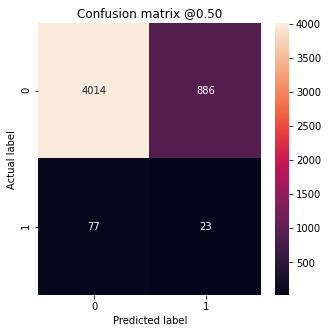

In [ ]:
cm = plot_cm(matrix_labels, matrix_predictions)

In [ ]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

def precision(label,confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()

def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def f1_score(pre,rec):
  return 2*(pre*rec) / (pre+rec)

In [ ]:
acc = accuracy(cm)
acc

0.8074

In [ ]:
pre = precision(1,cm)
pre

0.025302530253025302

In [ ]:
rec = recall(1,cm)
rec

0.23

In [ ]:
f1 = f1_score(pre,rec)
f1

0.04558969276511397

###PulpFiction

In [ ]:
pulpfiction_predictions = predict_results.loc[1].values.tolist()
pulpfiction_labels = labels.loc[7].values.tolist()

In [ ]:
pulpfiction_predictions = np.array(pulpfiction_predictions[1:])
pulpfiction_predictions

array([0.56746733, 0.68188828, 0.76536947, ..., 0.02569781, 0.02569781,
       0.02569781])

In [ ]:
pulpfiction_labels = np.array(pulpfiction_labels[1:])
pulpfiction_labels

array([0., 0., 0., ..., 0., 0., 0.])

Legitimate Transactions Detected (True Negatives):  4203
Legitimate Transactions Incorrectly Detected (False Positives):  565
Fraudulent Transactions Missed (False Negatives):  204
Fraudulent Transactions Detected (True Positives):  28
Total Fraudulent Transactions:  232


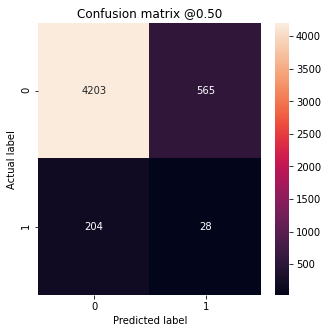

In [ ]:
cm = plot_cm(pulpfiction_labels, pulpfiction_predictions)

In [19]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

def precision(label,confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()

def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def f1_score(pre,rec):
  return 2*(pre*rec) / (pre+rec)

In [ ]:
acc = accuracy(cm)
acc

0.8462

In [ ]:
pre = precision(1,cm)
pre

0.047217537942664416

In [ ]:
rec = recall(1,cm)
rec

0.1206896551724138

In [ ]:
f1 = f1_score(pre,rec)
f1

0.06787878787878787

#Pirate

In [11]:
import numpy as np

In [9]:
pirate_predictions = predict_results.loc[7].values.tolist()
pirate_labels = labels.loc[5].values.tolist()

In [17]:
pirate_predictions = np.array(pirate_predictions[1:])
pirate_predictions

array([0.55348462, 0.59863979, 0.62628728, ..., 0.13229316, 0.09393606,
       0.05993787])

In [18]:
pirate_labels = np.array(pirate_labels[1:])
pirate_labels

array([0., 0., 0., ..., 0., 0., 0.])

Legitimate Transactions Detected (True Negatives):  3856
Legitimate Transactions Incorrectly Detected (False Positives):  633
Fraudulent Transactions Missed (False Negatives):  445
Fraudulent Transactions Detected (True Positives):  66
Total Fraudulent Transactions:  511


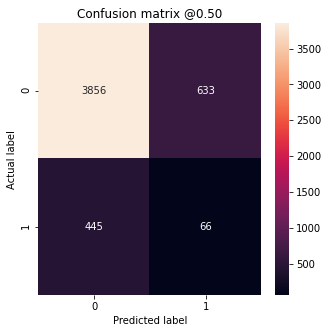

In [20]:
cm = plot_cm(pirate_labels, pirate_predictions)

In [23]:
acc = accuracy(cm)
pre = precision(1,cm)
rec = recall(1,cm)
print('acc',acc,'pre',pre,'rec',rec)

acc 0.7844 pre 0.0944206008583691 rec 0.12915851272015655


#street_dance

Legitimate Transactions Detected (True Negatives):  3996
Legitimate Transactions Incorrectly Detected (False Positives):  428
Fraudulent Transactions Missed (False Negatives):  504
Fraudulent Transactions Detected (True Positives):  72
Total Fraudulent Transactions:  576
acc 0.8136 pre 0.144 rec 0.125


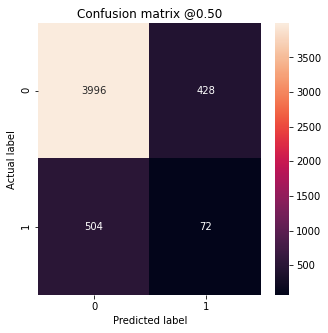

In [27]:
predictions = predict_results.loc[6].values.tolist()
labels = ground_labels.loc[1].values.tolist()
predictions = np.array(predictions[1:])
labels = np.array(labels[1:])
cm = plot_cm(labels, predictions)
acc = accuracy(cm)
pre = precision(1,cm)
rec = recall(1,cm)
print('acc',acc,'pre',pre,'rec',rec)

#Alice

Legitimate Transactions Detected (True Negatives):  4067
Legitimate Transactions Incorrectly Detected (False Positives):  479
Fraudulent Transactions Missed (False Negatives):  403
Fraudulent Transactions Detected (True Positives):  51
Total Fraudulent Transactions:  454
acc 0.8236 pre 0.09622641509433963 rec 0.11233480176211454


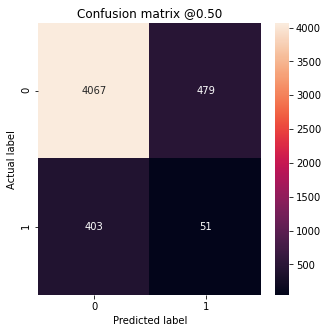

In [28]:
predictions = predict_results.loc[4].values.tolist()
labels = ground_labels.loc[6].values.tolist()
predictions = np.array(predictions[1:])
labels = np.array(labels[1:])
cm = plot_cm(labels, predictions)
acc = accuracy(cm)
pre = precision(1,cm)
rec = recall(1,cm)
print('acc',acc,'pre',pre,'rec',rec)

#Sherlock

Legitimate Transactions Detected (True Negatives):  4100
Legitimate Transactions Incorrectly Detected (False Positives):  696
Fraudulent Transactions Missed (False Negatives):  161
Fraudulent Transactions Detected (True Positives):  43
Total Fraudulent Transactions:  204
acc 0.8286 pre 0.058186738836265225 rec 0.2107843137254902


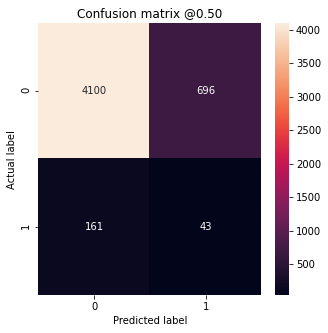

In [29]:
predictions = predict_results.loc[0].values.tolist()
labels = ground_labels.loc[4].values.tolist()
predictions = np.array(predictions[1:])
labels = np.array(labels[1:])
cm = plot_cm(labels, predictions)
acc = accuracy(cm)
pre = precision(1,cm)
rec = recall(1,cm)
print('acc',acc,'pre',pre,'rec',rec)

#Amelie

Legitimate Transactions Detected (True Negatives):  4339
Legitimate Transactions Incorrectly Detected (False Positives):  452
Fraudulent Transactions Missed (False Negatives):  184
Fraudulent Transactions Detected (True Positives):  25
Total Fraudulent Transactions:  209
acc 0.8728 pre 0.05241090146750524 rec 0.11961722488038277


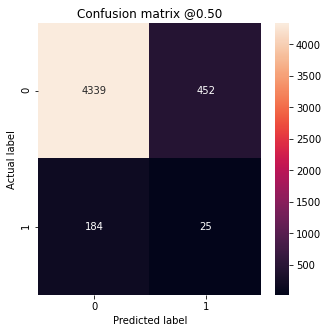

In [30]:
predictions = predict_results.loc[2].values.tolist()
labels = ground_labels.loc[3].values.tolist()
predictions = np.array(predictions[1:])
labels = np.array(labels[1:])
cm = plot_cm(labels, predictions)
acc = accuracy(cm)
pre = precision(1,cm)
rec = recall(1,cm)
print('acc',acc,'pre',pre,'rec',rec)

#Life of pi

Legitimate Transactions Detected (True Negatives):  4097
Legitimate Transactions Incorrectly Detected (False Positives):  686
Fraudulent Transactions Missed (False Negatives):  180
Fraudulent Transactions Detected (True Positives):  37
Total Fraudulent Transactions:  217
acc 0.8268 pre 0.051175656984785614 rec 0.17050691244239632


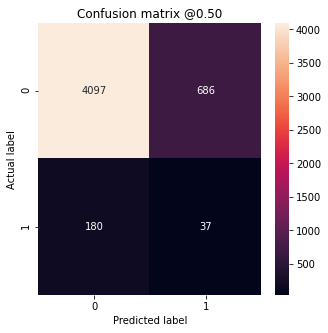

In [31]:
predictions = predict_results.loc[5].values.tolist()
labels = ground_labels.loc[0].values.tolist()
predictions = np.array(predictions[1:])
labels = np.array(labels[1:])
cm = plot_cm(labels, predictions)
acc = accuracy(cm)
pre = precision(1,cm)
rec = recall(1,cm)
print('acc',acc,'pre',pre,'rec',rec)